##MLP

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# image 를 tensor 로 바꾸고 normalize 하는 transform 정의
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5),)])

# train set 과 test set Load
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

# validation set 준비
indices = list(range(len(trainset)))
np.random.shuffle(indices)

# 20% valid set from train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:22<00:00, 1156267.99it/s]


Extracting /Users/jiwoossong/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/jiwoossong/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 135847.85it/s]


Extracting /Users/jiwoossong/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/jiwoossong/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 892439.69it/s] 


Extracting /Users/jiwoossong/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/jiwoossong/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6409105.67it/s]

Extracting /Users/jiwoossong/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/jiwoossong/.pytorch/F_MNIST_data/FashionMNIST/raw



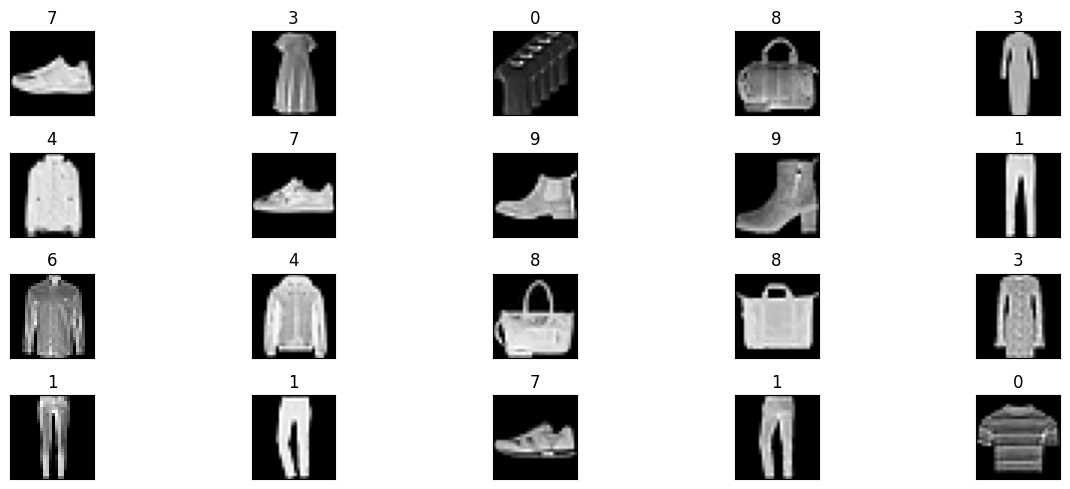

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
print(dataiter)
images, labels = next(dataiter)


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')

  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [4]:
# Model build

class Classifier(nn.Module): # nn.Module상속
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    
    self.dropout = nn.Dropout(0,2)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    
    F.log_softmax(self.fc4(x), dim=1)
    
    return x

In [5]:
model = Classifier()

criterion = nn.NLLLoss() #Negative Log Likelihood Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [22]:
valid_loss_min = np.Inf
epochs = 10
steps = 0
model.train() # 모델 학습 준비
train_losses, valid_losses = [], []

for e in range(epochs):
  running_loss = 0
  valid_loss = 0

  # train the model
  for images, labels in trainloader:
    optimizer.zero_grad()
    pred = model(images)
    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step() # 모델 학습
    running_loss += loss.item() * images.size(0)
    
  # validation the model
  for images, labels in validloader:
    pred = model(images)
    loss = criterion(pred, labels)
    valid_loss += loss.item() * images.size(0)
  
  running_loss = running_loss / len(trainloader.sampler)
  valid_loss = valid_loss / len(validloader.sampler)
    
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      e+1,
      running_loss,
      valid_loss
  ))

  if valid_loss < valid_loss_min:
    print('validation loss decreased({:.6f} --> {:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: nan 	Validation Loss: nan
Epoch: 2 	Training Loss: nan 	Validation Loss: nan
Epoch: 3 	Training Loss: nan 	Validation Loss: nan
Epoch: 4 	Training Loss: nan 	Validation Loss: nan
Epoch: 5 	Training Loss: nan 	Validation Loss: nan
Epoch: 6 	Training Loss: nan 	Validation Loss: nan
Epoch: 7 	Training Loss: nan 	Validation Loss: nan
Epoch: 8 	Training Loss: nan 	Validation Loss: nan
Epoch: 9 	Training Loss: nan 	Validation Loss: nan
Epoch: 10 	Training Loss: nan 	Validation Loss: nan


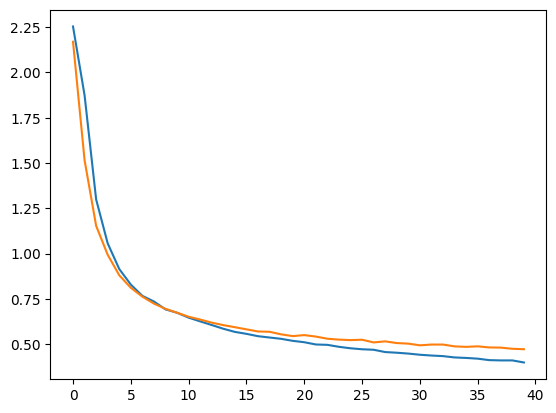

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

In [18]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()
for images, labels in testloader:
  # forword pass
  output = model(images)
  
  # calc loss
  criterion(output, labels)

  # update test loss
  test_loss += loss.item() * images.size(0)
  _, pred = torch.max(output, 1)
  
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss / len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))

  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)
))


Test Loss: nan

Test Accuracy of     0: 100% (1000/1000)
Test Accuracy of     1:  0% ( 0/1000)
Test Accuracy of     2:  0% ( 0/1000)
Test Accuracy of     3:  0% ( 0/1000)
Test Accuracy of     4:  0% ( 0/1000)
Test Accuracy of     5:  0% ( 0/1000)
Test Accuracy of     6:  0% ( 0/1000)
Test Accuracy of     7:  0% ( 0/1000)
Test Accuracy of     8:  0% ( 0/1000)
Test Accuracy of     9:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


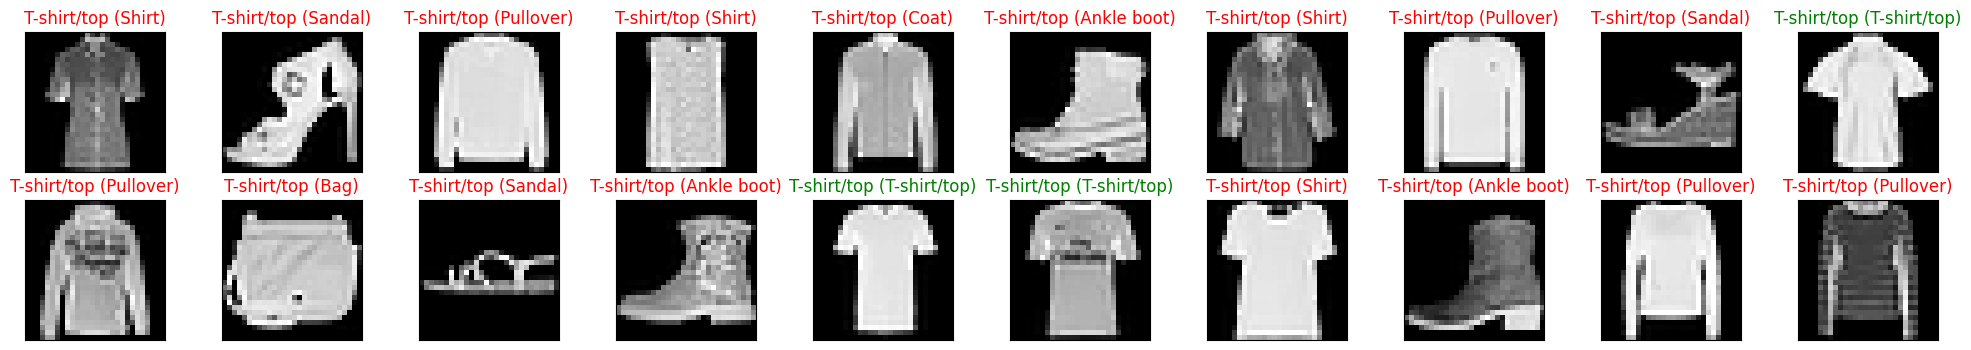

In [19]:
label_info = {0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

dataiter = iter(testloader)
images, labels = next(dataiter)

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title("{} ({})".format(label_info[preds[idx].item()], label_info[labels[idx].item()]),
               color=("green" if preds[idx]==labels[idx] else "red"))

##CNN

GPU 사용

런타임 -> 런타임 유형 변경 -> GPU 선택

###Convolution operation 효과 확인 with 정적인 filter

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_sample_image
import numpy as np

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [ ]:
batch_size, height, width, channels = images.shape
print("batch_size : ",batch_size,"\nheight * width : ", height,"*",width,"\nchannels :", channels)

batch_size :  2 
height * width :  427 * 640 
channels : 3


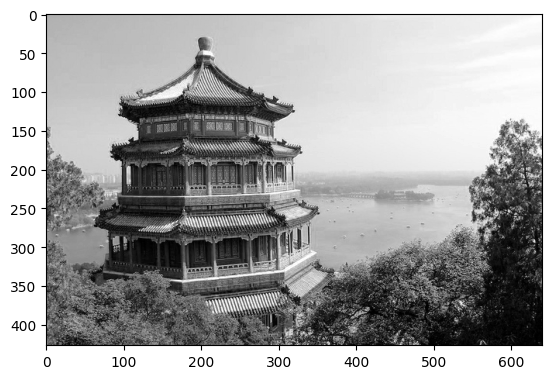

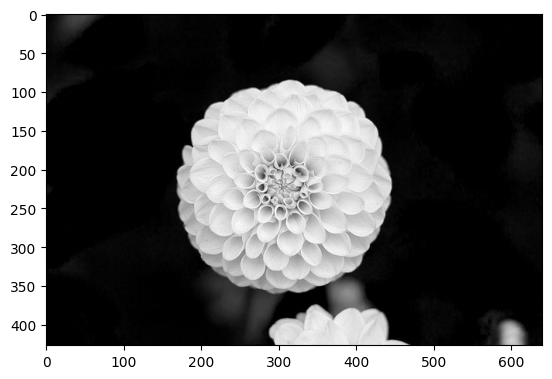

In [ ]:
plt.imshow(images[0][:,:,0], cmap='gray')
plt.show()
plt.imshow(images[1][:,:,0], cmap='gray')
plt.show()

In [ ]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

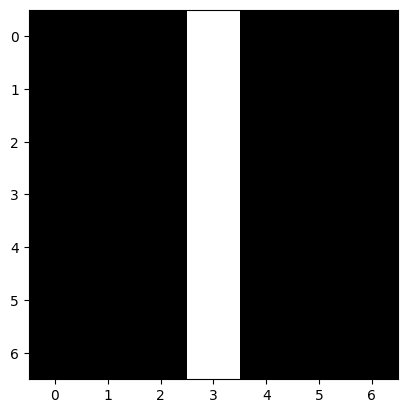

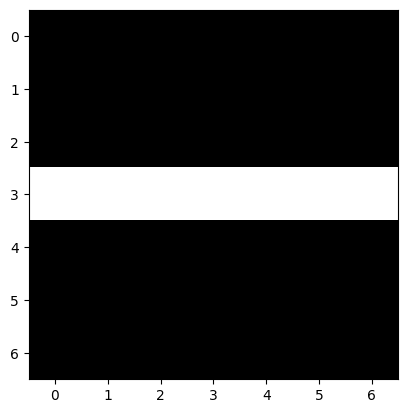

In [ ]:
# Visualizing
plt.imshow(filters[:, :, 0, 0],cmap="gray") # First filter
plt.show()
plt.imshow(filters[:, :, 0, 1],cmap="gray") # Second filter
plt.show()

(421, 634, 1)


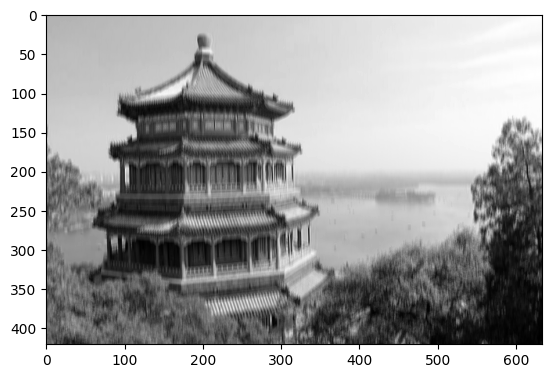

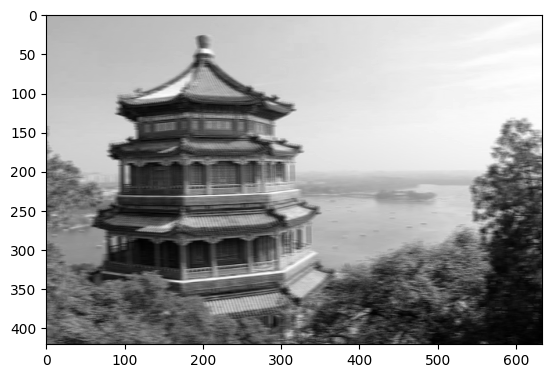

In [ ]:
# outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
filter = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7)
filter.weight = torch.nn.Parameter(torch.Tensor(np.array([[filters[:, :, 0, 0]]])))
output1 = filter(torch.Tensor(images[0][None, :,:,0]))
output1 = output1.permute(1, 2, 0).detach().numpy()
print(output1.shape)
plt.imshow(output1, cmap="gray") # plot 1st image's 1st feature map
plt.show()


filter = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7)
filter.weight = torch.nn.Parameter(torch.Tensor(np.array([[filters[:, :, 0, 1]]])))
output2 = filter(torch.Tensor(images[0][None, :,:,0]))
output2 = output2.permute(1, 2, 0).detach().numpy()
plt.imshow(output2, cmap="gray") # plot 1st image's 2nd feature map
plt.show()

outputs = [output1, output2]

In [ ]:
# Function for cropping
def crop(images):
  return images[150:220, 130:250]

china_vertical


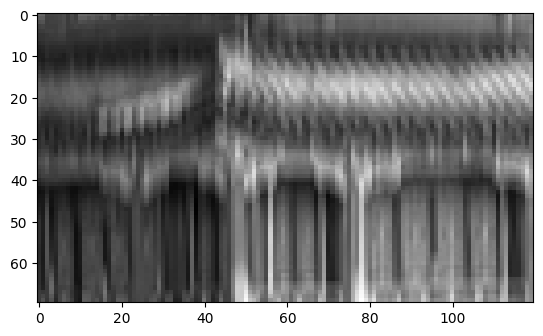

china_horizontal


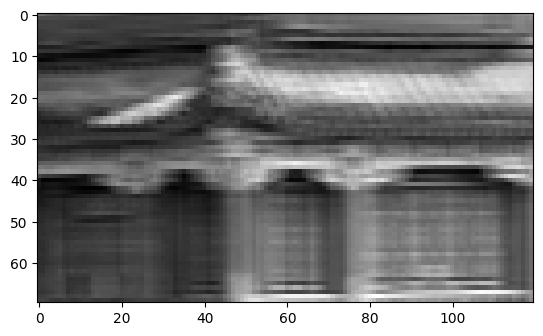

In [ ]:
for feature_map_index, filename in enumerate(["china_vertical","china_horizontal"]):
  print(filename)
  plt.imshow(crop(outputs[feature_map_index]),cmap="gray")
  plt.show()

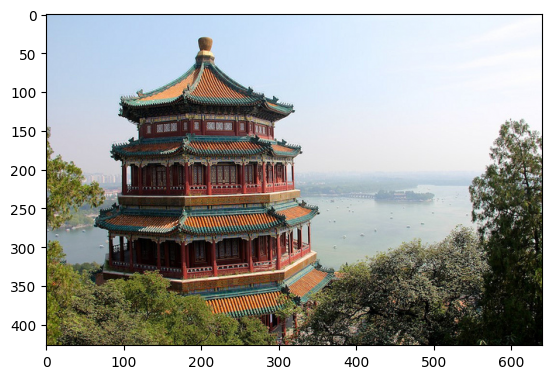

(427, 640, 3)
(1, 421, 634, 3)


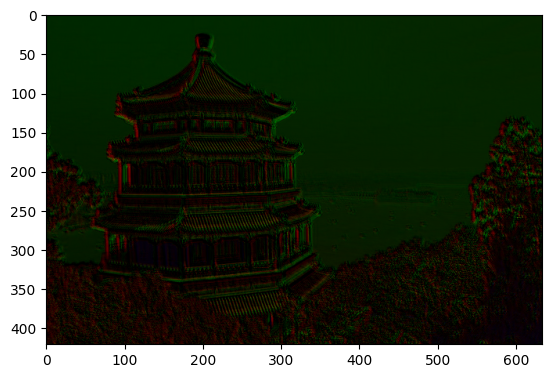

In [ ]:
plt.imshow(images[0][:,:,:])
plt.show()

filter = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=7)
print(images[0].shape)
output3 = filter(torch.Tensor(images[0][None, :, :, :]).permute(0, 3, 1, 2))
output3 = output3.permute(0, 2, 3, 1).detach().numpy()
print(output3.shape)
plt.imshow(output3[0], cmap="gray") # plot 1st image's 1st feature map
plt.show()

Pooling layer

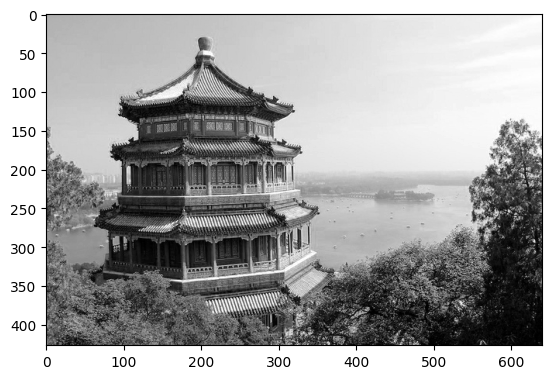

Input's H*W :  (427, 640)


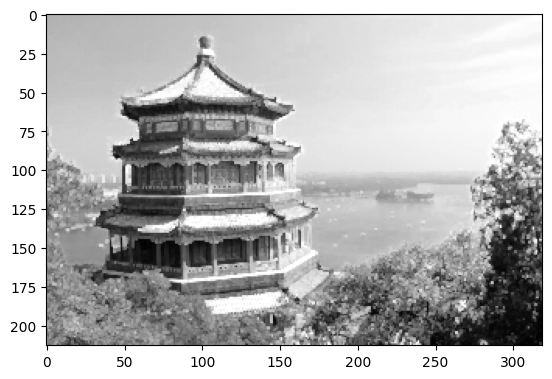

Output's H*W :  (213, 319)


In [ ]:
# pooling layer
max_pool = torch.nn.MaxPool2d(3, 2)
outputs = max_pool(torch.Tensor(images[None, 0, :, :, 0])).detach().numpy()
plt.imshow(images[0, :, :, 0], cmap="gray")
plt.show()
print("Input's H*W : ",images[0, :, :, 0].shape)
plt.imshow(outputs[0, :, :], cmap="gray")
plt.show()
print("Output's H*W : ",outputs[0, :, :].shape)

###CNN 기본구조 학습

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [ ]:
transform = transforms.Compose()

batch_size =

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


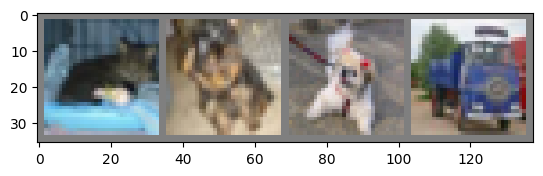

cat   dog   dog   truck


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):

    def forward(self, x):


net = Net()

net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion =
optimizer =

In [ ]:
epochs = 50

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data


        # zero the parameter gradients


        # forward + backward + optimize


        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches

    print(f'[{epoch + 1}, loss: {running_loss / len(trainloader):.3f}')


print('Finished Training')

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

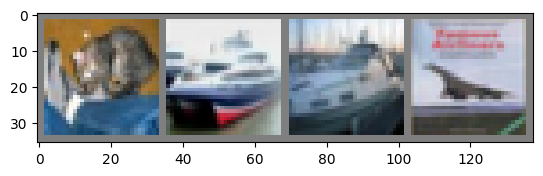

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# load model


<All keys matched successfully>

In [ ]:
# forward data into model


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   ship  ship  plane


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:

        # calculate outputs by running images through the network

        # the class with the highest energy is what we choose as prediction

        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:

        # collect the correct predictions for each class



# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

###**모델** 구조 변경

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 200

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):

    def forward(self, x):


net = Net()

net.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# Various optimizers exist
# optimizer = optim.Adam(net.parameters(), lr=0.005, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [ ]:
epochs = 300

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data

        # zero the parameter gradients

        # forward + backward + optimize

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches

    print(f'[{epoch + 1}, loss: {running_loss / len(trainloader):.3f}]')


print('Finished Training')

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        # calculate outputs by running images through the network

        # the class with the highest energy is what we choose as prediction

        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


###ResNet

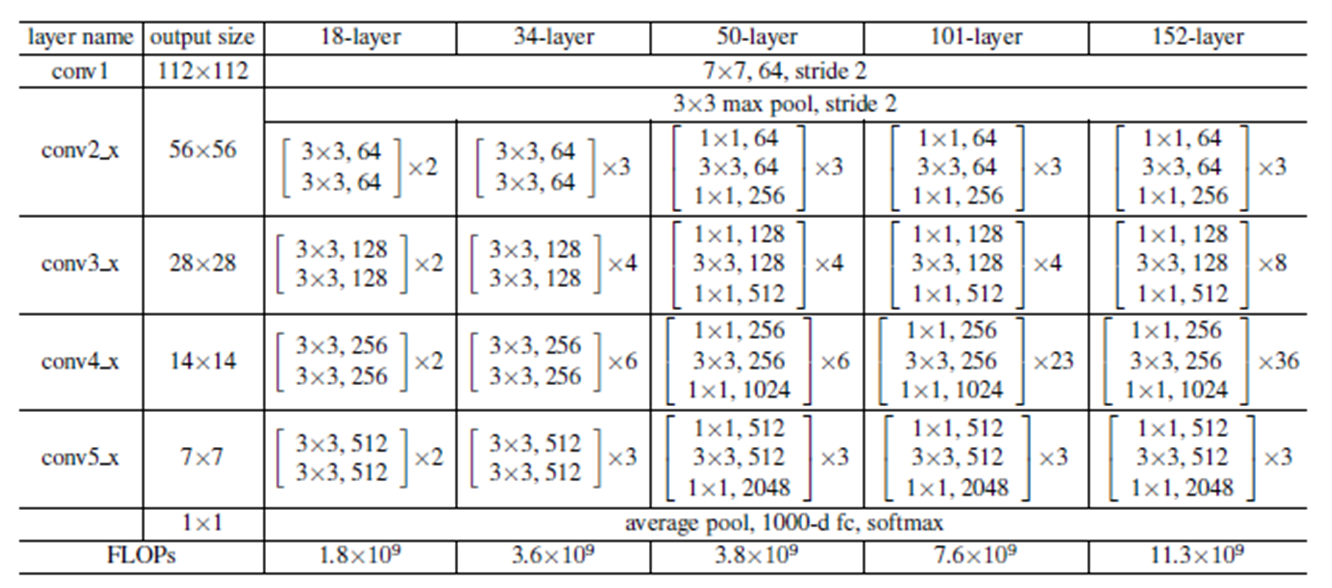

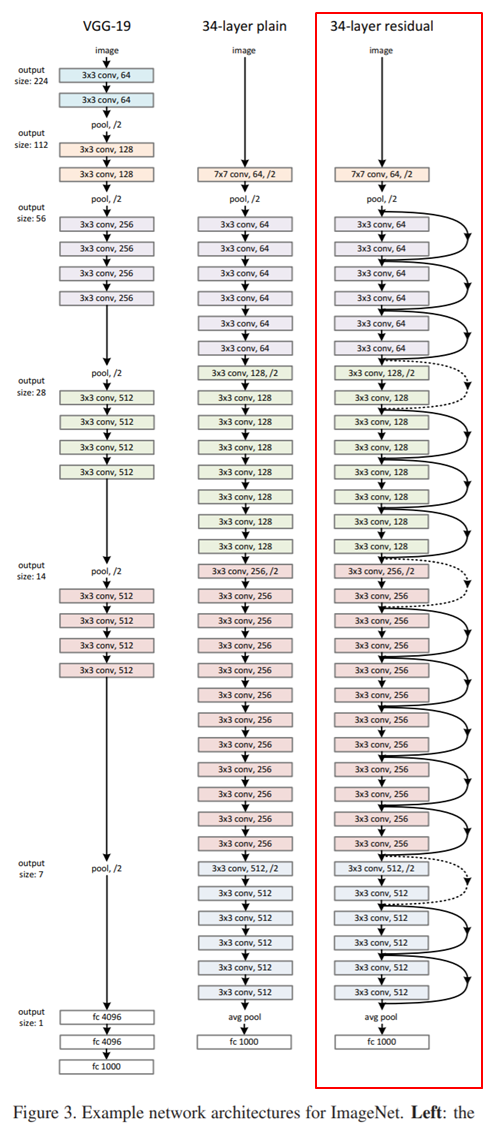

In [ ]:
import torch
import math
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image

In [ ]:
transform = transforms.Compose([transforms.Grayscale(3), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

indices = list(range(len(trainset)))
np.random.shuffle(indices)

split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
## 이전 CNN tutorial에서 사용한 코드 셋팅.

def train_mode(model, optimizer, criterion, epochs):
    valid_loss_min = np.Inf
    steps = 0
    model.train()  # 모델 학습 준비
    train_losses, valid_losses = [], []

    for e in range(epochs):
        running_loss = 0
        valid_loss = 0

        # train the model
        for images, labels in trainloader:

            running_loss += loss.item() * images.size(0)

        for images, labels in validloader:

            valid_loss += loss.item() * images.size(0)

        running_loss = running_loss / len(trainloader.sampler)
        valid_loss = valid_loss / len(validloader.sampler)
        train_losses.append(running_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            e + 1,
            running_loss,
            valid_loss
        ))

        if valid_loss < valid_loss_min:
            print('validation loss decreased({:.6f} --> {:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss

    return train_losses, valid_losses

In [ ]:
def test_mode(model, criterion):
    test_loss = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    for images, labels in testloader:
        # forword pass

        # calc loss

        # update test loss

        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    test_loss = test_loss / len(testloader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
                  (str(i), 100 * class_correct[i] / class_total[i],
                   np.sum(class_correct[i]), np.sum(class_total[i])))

        else:
            print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

In [ ]:
def evaluation(model):
    label_info = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

    dataiter = iter(testloader)
    images, labels = next(dataiter)

    output = model(images)
    _, preds = torch.max(output, 1)

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, int(20 / 2), idx + 1, xticks=[], yticks=[])

        # Convert the torch tensor to a PIL Image
        img = to_pil_image(images[idx])
        ax.imshow(np.asarray(img))  # Convert to NumPy array before displaying

        ax.set_title("{} ({})".format(label_info[preds[idx].item()], label_info[labels[idx].item()]),
                     color=("green" if preds[idx] == labels[idx] else "red"))


torch hub 사용하기

In [ ]:
### ResNet simple version 18, 34, 50, 101, 152

model =

criterion =
optimizer =
epochs =

In [ ]:
# ResNet 학습 & loss 확인
train_losses, valid_losses = train_mode(model, optimizer, criterion, epochs)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

In [ ]:
# ResNet test
test_mode(model, criterion)

In [ ]:
# 학습한 모델 plt로 확인해보기
evaluation(model)

In [ ]:
############ ResNet 심화 버전
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):

    def forward(self, x):


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):

    def forward(self, x):


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):


    def _make_layer(self, block, planes, blocks, stride=1):

    def forward(self, x):


def generate_model(model_depth, pretrained=False, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152]

    if model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
        if pretrained:
            model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))

    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
        if pretrained:
            model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))

    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
        if pretrained:
            model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))

    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
        if pretrained:
            model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))

    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
        if pretrained:
            model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))

    return model

In [ ]:
# 이전과 똑같이 학습 셋팅
model = generate_model(model_depth=18, pretrained=True)
model.eval()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 10

print(model)

In [ ]:
# ResNet 테스트
test_mode(model, criterion)

In [ ]:
# 학습한 모델 plt로 확인해보기
evaluation(model)